
========== INITIAL VALIDATION ==========
Customer sheet shape: (53413, 5)
Waterfall sheet shape: (49228, 6)
Invalid date rows removed: 3

========== DESCRIPTIVE STATISTICS ==========

Overall Revenue Summary:
count    53410.000000
mean       469.720187
std        843.364644
min     -10856.830000
25%         66.120000
50%        240.980000
75%        590.595900
max      19595.955600
Name: revenue, dtype: float64

Revenue by Company:
             count        mean          std           min    25%     50%  \
company                                                                    
Company 1  17647.0  549.386709   888.065063 -10856.830000   32.0  290.00   
Company 2  18579.0  225.434668   350.988685   -429.579550   45.6  114.00   
Company 3  17184.0  652.023815  1078.610520  -1507.956667  184.5  392.18   

              75%         max  
company                        
Company 1  755.00  13520.0700  
Company 2  285.00   5280.0924  
Company 3  770.24  19595.9556  

Top 10 Customers by T

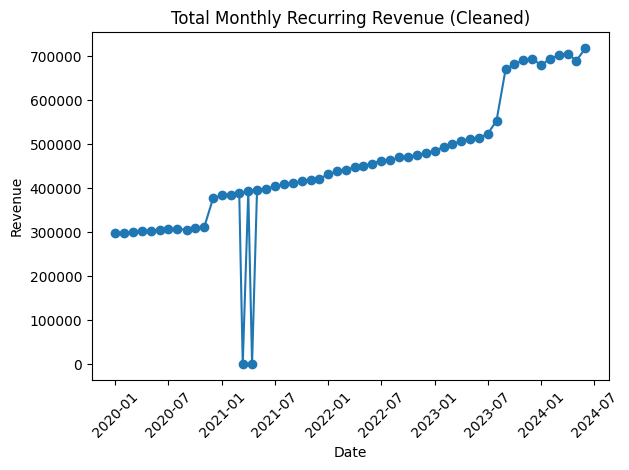


========== CUSTOMER DYNAMICS ==========

Active Customers by Month:
         date  active_customers
0  2020-01-01               656
1  2020-02-01               656
2  2020-03-01               656
3  2020-04-01               656
4  2020-05-01               656
5  2020-06-01               656
6  2020-07-01               656
7  2020-08-01               656
8  2020-09-01               656
9  2020-10-01               656
10 2020-11-01               656
11 2020-12-01              1043

Total Churn Events: 1653

========== ANOMALY DETECTION ==========

Extreme Revenue Change Events:
            customer       date  revenue_change
49407  Customer 1038 2023-09-01         2237.83
49922  Customer 1048 2020-01-01       -11914.63
49923  Customer 1048 2020-02-01        11395.36
49924  Customer 1048 2020-02-01       -11395.36
49925  Customer 1048 2020-03-01        11938.90

Negative Revenue Records: 97


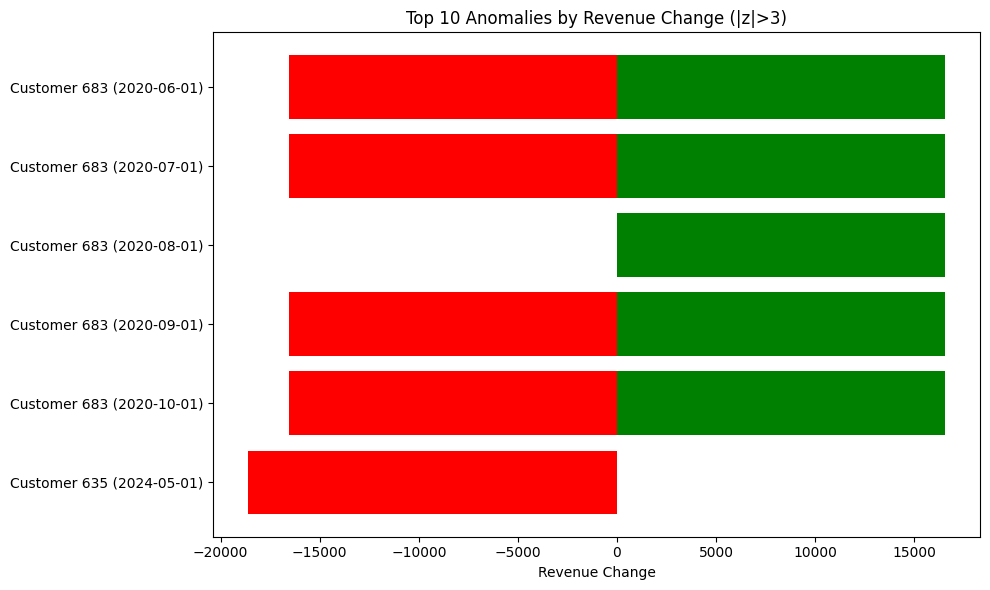


========== WATERFALL TAB ANALYSIS ==========

Waterfall Revenue Summary:
count    49228.000000
mean       433.695928
std        822.975884
min     -18615.330000
25%         45.600000
50%        214.320000
75%        540.360000
max      19591.005600
Name: revenue, dtype: float64

Waterfall Category Distribution:
category
Opening RR                    43464
Back to base                   3786
Downsell                       1377
New name                        246
Churn                           185
Delta with reported RR          126
Returning customer               18
Temporary churn                  16
Prior credit note impact          6
Current credit note impact        4
Name: count, dtype: int64

Waterfall Monthly Breakdown:
        date                category    revenue
0 2021-01-01            Back to base  14212.521
1 2021-01-01                   Churn  -3496.013
2 2021-01-01  Delta with reported RR      0.000
3 2021-01-01                Downsell  -7178.787
4 2021-01-01         

In [16]:
# ==========================================================
# FINAL EDA SCRIPT
# Recurring Revenue by Customer + Waterfall
# Cleaned Dataset (Robust Version)
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# FILE PATH
# ----------------------------------------------------------
FILE_PATH = r"C:\Users\tkorz\OneDrive\Documents\revenue-analysis-case-study\data\processed\case_study_cleaned.xlsx"

# ----------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------
rr_customer = pd.read_excel(FILE_PATH, sheet_name="Recurring Revenue by Customer")
rr_waterfall = pd.read_excel(FILE_PATH, sheet_name="Recurring Revenue Waterfall")

print("\n========== INITIAL VALIDATION ==========")
print("Customer sheet shape:", rr_customer.shape)
print("Waterfall sheet shape:", rr_waterfall.shape)

# ----------------------------------------------------------
# SAFE DATE CONVERSION
# ----------------------------------------------------------
rr_customer["date"] = pd.to_datetime(rr_customer["date"], errors="coerce")
invalid_dates = rr_customer["date"].isna().sum()

print("Invalid date rows removed:", invalid_dates)

rr_customer = rr_customer.dropna(subset=["date"])

# Ensure revenue numeric
rr_customer["revenue"] = pd.to_numeric(rr_customer["revenue"], errors="coerce")
rr_customer = rr_customer.dropna(subset=["revenue"])


# ==========================================================
# 1️ DESCRIPTIVE STATISTICS
# ==========================================================

print("\n========== DESCRIPTIVE STATISTICS ==========")

print("\nOverall Revenue Summary:")
print(rr_customer["revenue"].describe())

print("\nRevenue by Company:")
print(rr_customer.groupby("company")["revenue"].describe())

print("\nTop 10 Customers by Total Revenue:")
top_customers = (
    rr_customer.groupby("customer")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print(top_customers)

# Revenue concentration (Pareto check)
total_revenue = rr_customer["revenue"].sum()
customer_totals = rr_customer.groupby("customer")["revenue"].sum().sort_values(ascending=False)
top_20pct_revenue = customer_totals.head(int(len(customer_totals) * 0.2)).sum()

print("\nRevenue Concentration (Top 20% Customers):")
print(round((top_20pct_revenue / total_revenue) * 100, 2), "%")


# ==========================================================
# 2️ MONTHLY TREND ANALYSIS
# ==========================================================

print("\n========== MONTHLY TREND ANALYSIS ==========")

# Clean monthly revenue trend
monthly = (
    rr_customer.groupby("date")["revenue"]
    .sum()
    .reset_index()
    .sort_values("date")
)

# Remove months with missing or zero revenue
monthly = monthly.dropna(subset=["revenue"])
monthly = monthly[monthly["revenue"] > 0]

monthly["previous"] = monthly["revenue"].shift(1)
monthly["mom_change"] = monthly["revenue"] - monthly["previous"]
monthly["mom_growth_%"] = (monthly["mom_change"] / monthly["previous"]) * 100

print("\nMonthly Revenue Snapshot (Cleaned):")
print(monthly.head(12))

# Plot clean monthly revenue trend
plt.figure()
plt.plot(monthly["date"], monthly["revenue"], marker='o')
plt.title("Total Monthly Recurring Revenue (Cleaned)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ==========================================================
# 3️ CUSTOMER DYNAMICS
# ==========================================================

print("\n========== CUSTOMER DYNAMICS ==========")

# Active customers per month
active_customers = (
    rr_customer.groupby("date")["customer"]
    .nunique()
    .reset_index(name="active_customers")
)

print("\nActive Customers by Month:")
print(active_customers.head(12))

# Revenue changes per customer
rr_customer = rr_customer.sort_values(["customer", "date"])
rr_customer["previous_revenue"] = rr_customer.groupby("customer")["revenue"].shift(1)
rr_customer["revenue_change"] = rr_customer["revenue"] - rr_customer["previous_revenue"]

# Churn detection
churn_events = rr_customer[
    (rr_customer["previous_revenue"] > 0) & (rr_customer["revenue"] == 0)
]

print("\nTotal Churn Events:", len(churn_events))


# ==========================================================
# 4️ ANOMALY DETECTION
# ==========================================================

print("\n========== ANOMALY DETECTION ==========")

std_dev = rr_customer["revenue_change"].std()
mean_change = rr_customer["revenue_change"].mean()

rr_customer["z_score"] = (
    (rr_customer["revenue_change"] - mean_change) / std_dev
)

anomalies = rr_customer[abs(rr_customer["z_score"]) > 3]

print("\nExtreme Revenue Change Events:")
print(anomalies[["customer", "date", "revenue_change"]].head())

negative_values = rr_customer[rr_customer["revenue"] < 0]
print("\nNegative Revenue Records:", len(negative_values))

# Bar chart for anomaly detection with two colors
anomalies_top10 = anomalies.reindex(anomalies["revenue_change"].abs().sort_values(ascending=False).index).head(10)
bar_colors = ['red' if val < 0 else 'green' for val in anomalies_top10["revenue_change"]]

plt.figure(figsize=(10, 6))
plt.barh(
    [f"{row['customer']} ({row['date'].date() if pd.notnull(row['date']) else 'No Date'})" for _, row in anomalies_top10.iterrows()],
    anomalies_top10["revenue_change"],
    color=bar_colors
    )
plt.xlabel("Revenue Change")
plt.title("Top 10 Anomalies by Revenue Change (|z|>3)")
plt.tight_layout()
plt.show()


# ==========================================================
# 5️ WATERFALL TAB ANALYSIS
# ==========================================================

print("\n========== WATERFALL TAB ANALYSIS ==========")

# Safe date handling
rr_waterfall["date"] = pd.to_datetime(rr_waterfall["date"], errors="coerce")
rr_waterfall = rr_waterfall.dropna(subset=["date"])

rr_waterfall["revenue"] = pd.to_numeric(rr_waterfall["revenue"], errors="coerce")
rr_waterfall = rr_waterfall.dropna(subset=["revenue"])

print("\nWaterfall Revenue Summary:")
print(rr_waterfall["revenue"].describe())

print("\nWaterfall Category Distribution:")
print(rr_waterfall["category"].value_counts())

waterfall_monthly = (
    rr_waterfall.groupby(["date", "category"])["revenue"]
    .sum()
    .reset_index()
)

print("\nWaterfall Monthly Breakdown:")
print(waterfall_monthly.head())


print("\n========== EDA COMPLETED SUCCESSFULLY ==========")